# Enhance LLMs using RAG and Hugging Face

In [1]:
!pip install --user transformers datasets torch faiss-cpu wget

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 7.6 MB/s eta 0:00:00a 0:00:01
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9685 sha256=8aa047ac5d48fc097d44c7aaa386a5e20277d887505a6874ee2d116f667cea15
  Stored in directory: /Users/ajborbz/Library/Caches/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [faiss-cpu]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install --user matplotlib scikit-learn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import wget
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer
import torch

import numpy as np
import random
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import numpy as np

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

/Users/ajborbz/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define Helper Function

In [4]:
def tsne_plot(data):
    # Apply t-SNE to reduce to 3D
    tsne = TSNE(n_components=3, random_state=42,perplexity=data.shape[0]-1)
    data_3d = tsne.fit_transform(data)
    
    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Assign colors for each point based on its index
    num_points = len(data_3d)
    colors = plt.cm.tab20(np.linspace(0, 1, num_points))
    
    # Plot scatter with unique colors for each point
    for idx, point in enumerate(data_3d):
        ax.scatter(point[0], point[1], point[2], label=str(idx), color=colors[idx])
    
    # Adding labels and titles
    ax.set_xlabel('TSNE Component 1')
    ax.set_ylabel('TSNE Component 2')
    ax.set_zlabel('TSNE Component 3')
    plt.title('3D t-SNE Visualization')
    plt.legend(title='Input Order')
    plt.show()

### Load and PreProcess data
Download the text file

In [5]:
filename = 'companyPolicies.txt'
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/6JDbUb_L3egv_eOkouY71A.txt'

# Use wget to download the file
wget.download(url, out=filename)
print('file downloaded')

file downloaded


### Reading and preprocessing the data

In [8]:
def read_and_split_text(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        text = f.read()
    paragraphs = text.split('\n')
    paragraphs = [para.strip() for para in paragraphs if len(para.strip()) > 0]
    return paragraphs

paragraphs = read_and_split_text(filename)
paragraphs[:10]


['1.\tCode of Conduct',
 'Our Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability.',
 'Integrity: We hold ourselves to the highest ethical standards. This means acting honestly and transparently in all our interactions, whether with colleagues, clients, or the broader community. We respect and protect sensitive information, and we avoid conflicts of interest.',
 "Respect: We embrace diversity and value each individual's contributions. Discrimination, harassment, or any form of disrespectful behavior is unacceptable. We create an inclusive environment where differences are celebrated and everyone is treated with dignity and courtesy.",
 'Accountability: We take responsibility for our actions and decisions. We follow all relevant laws and regulations, and we strive to continuously improve our practices. We report any potent

### sample 4 

In [9]:
for i in range(4):
    print(f"sample: {i} paragraph: {paragraphs[i]} \n" )

sample: 0 paragraph: 1.	Code of Conduct 

sample: 1 paragraph: Our Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability. 

sample: 2 paragraph: Integrity: We hold ourselves to the highest ethical standards. This means acting honestly and transparently in all our interactions, whether with colleagues, clients, or the broader community. We respect and protect sensitive information, and we avoid conflicts of interest. 

sample: 3 paragraph: Respect: We embrace diversity and value each individual's contributions. Discrimination, harassment, or any form of disrespectful behavior is unacceptable. We create an inclusive environment where differences are celebrated and everyone is treated with dignity and courtesy. 



In [10]:
%%capture
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')
context_tokenizer

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.


In [11]:
text = [("How are you?", "I am fine."), ("What's up?", "Not much.")]
print(text)

[('How are you?', 'I am fine.'), ("What's up?", 'Not much.')]


In [12]:
tokens_info=context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
tokens_info

{'input_ids': tensor([[ 101, 2129, 2024, 2017, 1029,  102, 1045, 2572, 2986, 1012,  102],
        [ 101, 2054, 1005, 1055, 2039, 1029,  102, 2025, 2172, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

- `token_type_ids`: These are segment embeddings used to distinguish different sentences or segments within the input. This is particularly useful in tasks that involve multiple types of input, such as question answering, where questions and context may need to be differentiated.

- `attention_mask`: The attention mask indicates which tokens should be attended to by the model. It has a value of 1 for actual tokens in the input sentences and 0 for padding tokens, ensuring that the model focuses only on meaningful data.

-  `input_ids`: These represent the indices of tokens in the tokenizer's vocabulary. To translate these indices back into readable tokens, you can use the method `convert_ids_to_tokens` provided by the tokenizer. Here's an example of how to use this method:


In [13]:
for s in tokens_info['input_ids']:
   print(context_tokenizer.convert_ids_to_tokens(s))

['[CLS]', 'how', 'are', 'you', '?', '[SEP]', 'i', 'am', 'fine', '.', '[SEP]']
['[CLS]', 'what', "'", 's', 'up', '?', '[SEP]', 'not', 'much', '.', '[SEP]']


**2. Encoding**: The tokenized texts are then fed into the `context_encoder`. This model processes the inputs and produces a pooled output for each, effectively compressing the information of an entire text into a single, dense vector embedding that represents the semantic essence of the text.

DPR models, including the ```DPRContextEncoder```, are based on the BERT architecture but specialize in dense passage retrieval. They differ from BERT in their training, which focuses on contrastive learning for retrieving relevant passages, while BERT is more general-purpose, handling various NLP tasks.


In [14]:
context_encoder = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The `context_tokenizer` and `context_encoder` work together to process text data, transforming paragraphs into contextual embeddings suitable for further NLP tasks. Here's how these components are applied to the first 20 paragraphs from a list:
   - The `context_tokenizer` takes the first 20 paragraphs and converts each into a sequence of token IDs, formatted specifically as input to a PyTorch model. This process includes:
     - **Padding**: To ensure uniformity, shorter text sequences are padded with zeros to reach the specified maximum length of 256 tokens.
     - **Truncation**: Longer texts are cut off at 256 tokens to maintain consistency across all inputs.
   - The tokenized data is then passed to the `context_encoder`, which processes these token sequences to produce contextual embeddings. Each output embedding vector from the encoder represents the semantic content of its corresponding paragraph, encapsulating key informational and contextual nuances.
   - The encoder outputs a PyTorch tensor where each row corresponds to a different paragraph's embedding. The shape of this tensor, determined by the number of paragraphs processed and the embedding dimensions, reflects the detailed, contextualized representation of each paragraph's content.

In [15]:
#shuffling samples so that the samples are not ordered based on the category they belong to
random.shuffle(paragraphs)

In [16]:
tokens=context_tokenizer( paragraphs[:20], return_tensors='pt', padding=True, truncation=True, max_length=256) 
tokens
outputs=context_encoder(**tokens)
outputs.pooler_output

tensor([[ 0.2619,  0.4822,  0.3748,  ..., -0.3538, -0.5486, -0.2843],
        [ 0.4570,  0.4176, -0.1697,  ..., -0.4451, -0.2361, -0.2666],
        [ 0.3966,  0.2065,  0.1497,  ..., -0.2425, -0.2382, -0.0184],
        ...,
        [ 0.4561,  0.3122,  0.1356,  ..., -0.2938, -0.4350,  0.0328],
        [ 0.2495,  0.0156,  0.0455,  ..., -0.3945, -0.7374, -0.1193],
        [ 0.4182, -0.2022,  0.3758,  ...,  0.0519, -0.1652,  0.4671]],
       grad_fn=<SliceBackward0>)

**t-SNE (t-Distributed Stochastic Neighbor Embedding)** is an effective method for visualizing high-dimensional data, making it particularly useful for analyzing outputs from ```DPRContextEncoder``` models. The ```DPRContextEncoder``` encodes passages into dense vectors that capture their semantic meanings within a high-dimensional space. Applying t-SNE to these dense vectors allows you to reduce their dimensionality to two or three dimensions. This reduction creates a visual representation that preserves the relationships between passages, enabling you to explore clusters of similar passages and discern patterns that might otherwise remain hidden in the high-dimensional space. The resulting plots provide insights into how the model differentiates between different types of passages and reveal the inherent structure within the encoded data.


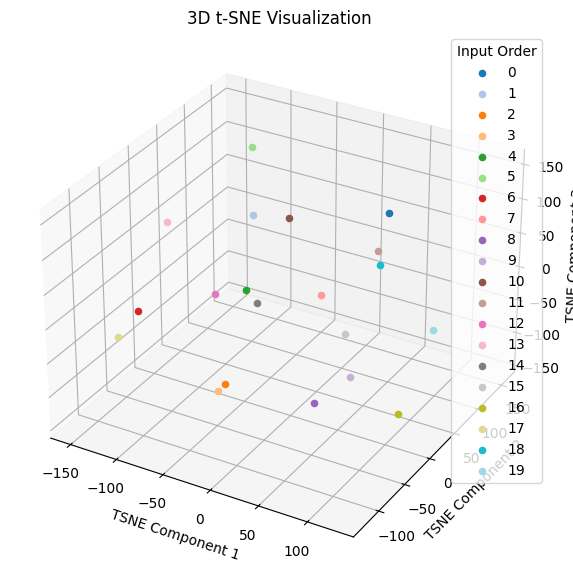

In [17]:
tsne_plot(outputs.pooler_output.detach().numpy())

In [18]:
print("sample 16:", paragraphs[16])

sample 16: Compliance: Adhere to all pertinent laws and regulations concerning mobile phone usage, including those related to data protection and privacy.


In [19]:
print("sample 12:", paragraphs[12])

sample 12: Review of Policy: This policy will be reviewed periodically to ensure its alignment with evolving legal requirements and best practices for maintaining a healthy and safe workplace.


Both samples discuss diversity. Rather than relying solely on visual inspection, distances between embeddings are employed to determine the relevance of retrieved documents or passages. This involves comparing the query’s embedding with the embeddings of candidate documents, enabling a precise and objective measure of relevance.


All individual embeddings generated from the texts are then aggregated into a single `NumPy` array. This aggregation is essential for subsequent processing steps, such as indexing, which facilitates efficient similarity searches.

This methodological approach efficiently transforms paragraphs into a form that retains crucial semantic information in a compact vector format, making it ideal for the retrieval tasks necessary in this lab. Now, compile a list containing each sample, where each sample has specific dimensions.


In [20]:
embeddings=[]
for text in paragraphs[0:5]:
    inputs = context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
    outputs = context_encoder(**inputs)
    embeddings.append(outputs.pooler_output)
    print("number of samples:")
    print(len(embeddings))
    print(" samples shape:")
    print(outputs.pooler_output.shape)

number of samples:
1
 samples shape:
torch.Size([1, 768])
number of samples:
2
 samples shape:
torch.Size([1, 768])
number of samples:
3
 samples shape:
torch.Size([1, 768])
number of samples:
4
 samples shape:
torch.Size([1, 768])
number of samples:
5
 samples shape:
torch.Size([1, 768])


In [21]:
torch.cat(embeddings).detach().numpy().shape

(5, 768)

In [22]:
def encode_contexts(text_list):
    # Encode a list of texts into embeddings
    embeddings = []
    for text in text_list:
        inputs = context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
        outputs = context_encoder(**inputs)
        embeddings.append(outputs.pooler_output)
    return torch.cat(embeddings).detach().numpy()

# you would now encode these paragraphs to create embeddings.
context_embeddings = encode_contexts(paragraphs)

### Creating and populating the FAISS index

After the text paragraphs are encoded into dense vector embeddings, the next crucial step is to create and populate an FAISS index. Facebook AI Similarity Search (FAISS) is an efficient library developed by Facebook for similarity search and clustering of dense vectors.

#### Overview of FAISS
- **Efficiency**: FAISS is designed for fast similarity search, which is particularly valuable when dealing with large datasets. It is highly suitable for tasks in natural language processing where retrieval speed is critical.
- **Scalability**: It effectively handles large volumes of data, maintaining performance even as dataset sizes increase.

#### Using IndexFlatL2
- **Index type**: `IndexFlatL2` is one of the simplest and most used indexes in FAISS. It computes the Euclidean distance (L2 norm) between the query vector and the dataset vectors to determine similarity. This method is straightforward but very effective for many use cases where the exact distance calculation is crucial.
- **Application**: This type of index is particularly useful in retrieval systems where the task is to find the most relevant documents or information that closely matches the query vector.

In [23]:
import faiss

# Convert list of numpy arrays into a single numpy array
embedding_dim = 768  # This should match the dimension of your embeddings
context_embeddings_np = np.array(context_embeddings).astype('float32')

# Create a FAISS index for the embeddings
index = faiss.IndexFlatL2(embedding_dim)
index.add(context_embeddings_np)  # Add the context embeddings to the index